# Bypass the RL, win money 🤑

This notebook is a pipeline for designing an efficient model for AWS Deepracer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from copy import copy, deepcopy
from time import time
import sys
from multiprocessing import Pool
from IPython.display import clear_output

# Part 1 - Compute the optimal racing line

In [2]:
TRACK_NAME = 'Aragon'
NUMBER_STEPS_PER_SECOND = 15 

In [3]:
action_space = pd.DataFrame(columns = ['id', 'speed', 'steering'])
action_sequence = []
optimal_racing_line = pd.DataFrame(columns = ['x', 'y', 'speed', 'distance_from_last_point'])

### Load the appropriate Track

In [4]:
# Load the waypoints
waypoints = np.load("../tracks/" + TRACK_NAME + ".npy")

# Build the geometrical objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [5]:
def print_shape(ax, shape, color='cyan'):
    line = LineString(shape)
    x, y = line.xy                                                                
    ax.plot(x, y, '.', color='gray')   
    ax.plot(x, y, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2) 

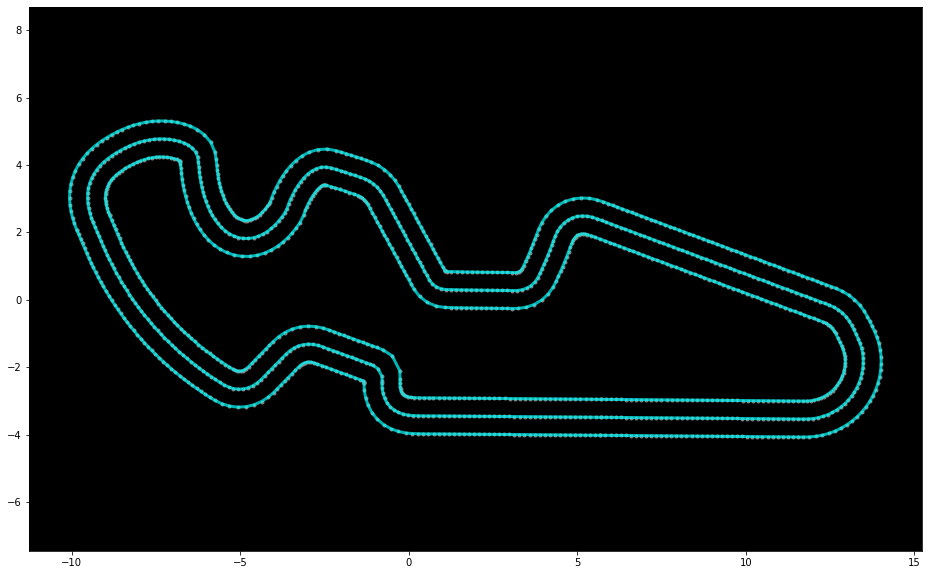

In [6]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)

# Part 2 - Compute the action space

In [7]:
# Path of the optimal racing line (.npy file)
fpath = "../racelines/Aragon-10000-8-2020-10-07-154119.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "Aragon"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

In [8]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [9]:
LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.33 # initial: 1.3
MAX_SPEED = 4 # initial: 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.3891251189812217


Constant multiple for optimal speed: 1.3891251189812217


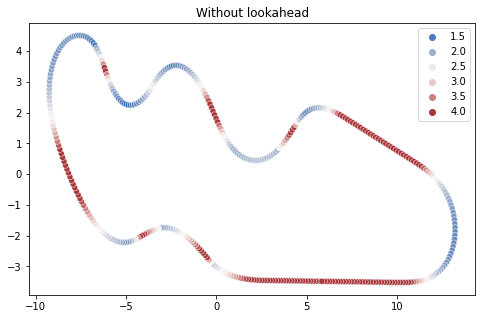

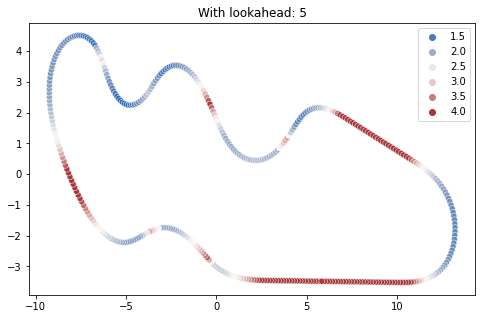

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [11]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 22.591607117213606 s


In [12]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [13]:
# Write to txt file
with open(f'optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

In [14]:
import math

# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

Text(0.5, 1.0, 'With lookahead: 5')

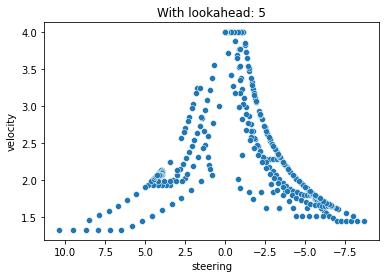

In [15]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

In [16]:
from scipy import stats

In [17]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -8 / stats.norm.ppf(0.05) # -15 / stats.norm.ppf(0.05)
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)


all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)

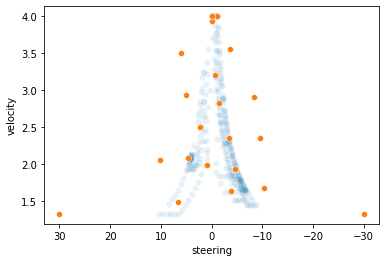

In [18]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-4 # -2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED,MAX_SPEED,MAX_SPEED],"steering":[30,-30,all_actions[all_actions.velocity==4.].steering.min(),all_actions[all_actions.velocity==4.].steering.max()]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

In [19]:
action_space = action_space_e
action_space['speed'] = action_space['velocity']
action_space['id'] = [i for i in range(21)]

# Part 3 - Compute the optimal racing line using only actions from the action space

### Mock (useful only for coding part 3 alone)

In [20]:
# Hardcoded action space to work with real values
# action_space = [[0,-2.1672,1.8288], [1,4.7048,3.746], [2,-0.5041,2.631], [3,-8.4625,1.7638], [4,9.4065,1.3834], [5,4.8393,2.1362], [6,-2.4795,2.1993], [7,-1.2504,3.1708], [8,-5.5957,1.5737], [9,-0.4535,3.9733], [10,4.7458,1.8055], [11,7.6023,2.5505], [12,-3.6409,3.653], [13,0.2825,1.5781], [14,-12.393,1.5628], [15,-9.039,2.4206], [16,10.9898,1.7996], [17,30.0,1.33], [18,-30.0,1.33], [19,-0.9195,4.0], [20,0.0,4.0]]
# action_space = pd.DataFrame(action_space, columns=('id','steering','speed'))

# # Mock racing line, to work with it
# optimal_racing_line = [[]]
# optimal_racing_line = pd.DataFrame(optimal_racing_line, columns=['x','y','speed','distance_from_last_point'])

### Utils

In [21]:
def compute_theta_from_coords(x0, x1, y0, y1):
    if x1 == x0:
        if y1 > y0:
            return np.pi / 2
        elif y1 < y0:
            return - np.pi / 2
        else:
            raise("Can't compute an angle when speed is null")
    elif x1 > x0:
        return np.arctan((y1-y0)/(x1-x0))
    else:
        return np.pi + np.arctan((y1-y0)/(x1-x0))

In [22]:
def take_theta_into_minus_pi_pi(theta):
    # Ensure rad_steering is between -pi and pi
    if theta > np.pi:
        return take_theta_into_minus_pi_pi(theta - 2 * np.pi)
    if theta < - np.pi:
        return take_theta_into_minus_pi_pi(theta + 2 * np.pi)
    else:
        return theta

### Compute action sequence

### Easiest method : compute the 'closest action' (lowest  euclidian distance) for each step

In [23]:
# # Note: to compute an effective euclidian distance, we need to normalize speed and steering

# def compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, theta0):
    
#     num_actions = len(optimal_racing_line) - 1
    
#     work_optimal_racing_line = pd.concat([pd.DataFrame({
#         'x': optimal_racing_line['x'][0] - np.cos(theta0),
#         'y': optimal_racing_line['y'][0] - np.sin(theta0),
#         'speed': 0,
#         'distance_from_last_point': 1
#     }, index=[0]), optimal_racing_line]).reset_index(drop=True)
    
#     action_sequence = []
#     rad_steerings = []
#     speeds = []
#     for i in range(num_actions): # There is a minus 2 since we need at least 3 points to determine a steering angle
#         # Compute geometrical data 
#         (x0, x1, x2) = (work_optimal_racing_line['x'][i+k] for k in range(3)) 
#         (y0, y1, y2) = (work_optimal_racing_line['y'][i+k] for k in range(3))
#         angle_1 = compute_theta_from_coords(x0, x1, y0, y1)
#         angle_2 = compute_theta_from_coords(x1, x2, y1, y2)
#         rad_steering = take_theta_into_minus_pi_pi(angle_2 - angle_1) # CAREFUL : those are radiants
#         rad_steerings.append(rad_steering)
#         speed = ((x1 - x0)**2 + (y1 - y0)**2)**0.5 * NUMBER_STEPS_PER_SECOND
#         speeds.append(speed)
#     # Compute distribution caracteristics, for normalization
#     mean_rad_steering = np.mean(rad_steerings)
#     std_rad_steering = np.std(rad_steerings)
#     mean_speed = np.mean(speeds)
#     std_speed = np.std(speeds)
    
#     for i in range(num_actions):
#         # Normalization
#         normalized_rad_steering = (rad_steerings[i] - mean_rad_steering) / std_rad_steering
#         normalized_speed = (speeds[i] - mean_speed) / std_speed
        
#         # The optimal action
#         opt_action = np.array([normalized_rad_steering, normalized_speed])
        
#         # Find the closest action from our action space (lowest euclidian distance)
#         chosen_action_id = 0
#         chosen_action_distance = 1000
#         for j in range(len(action_space)):
#             # Normalization
#             normalized_cur_rad_steering =  (action_space['steering'][j]*2*np.pi/360 - mean_rad_steering) / std_rad_steering
#             normalized_cur_speed =  (action_space['speed'][j] - mean_speed) / std_speed
            
#             # The current considered action
#             cur_action = np.array([normalized_cur_rad_steering, normalized_cur_speed])
            
#             distance_to_optimal = np.linalg.norm(opt_action - cur_action)
            
#             if distance_to_optimal < chosen_action_distance:
#                 chosen_action_id = action_space['id'][j]
#                 chosen_action_distance = distance_to_optimal
#         action_sequence.append(chosen_action_id)
    
#     return action_sequence

In [24]:
# action_sequence = compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, 0)

### A more complicated method : genetical algorithm

In [25]:
def compute_real_racing_line(action_sequence, action_space, x0, y0, theta0):
    xs = [x0]
    ys = [y0]

    cur_x = x0
    cur_y = y0
    cur_theta = theta0
    for action_id in action_sequence:
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        xs.append(cur_x)
        ys.append(cur_y)
    real_racing_line = pd.DataFrame({
        'x': xs,
        'y': ys
    })
    return real_racing_line

In [44]:
[x0, y0] = center_line[0]
theta0 = take_theta_into_minus_pi_pi(compute_theta_from_coords(center_line[0][0], center_line[1][0], center_line[0][1], center_line[1][1]))

In [45]:
# Helpers, used in almost every functions

# Check if point (x, y) is in the track
def check_if_car_in_track(x, y):
    point = Point(x, y)
    inner_polygon = Polygon(inner_border)
    outer_polygon = Polygon(outer_border)
    if outer_polygon.contains(point) and not inner_polygon.contains(point):
        return True
    else:
        return False

# Euclidian distance
def distance(x1, y1, x2, y2):
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

# Check the closest point from track from (x,y) and measure percentage of completion with this point
# Note: we need to include last percentage to handle multilaps
def get_percentage_completion(x, y, last_percentage):
    d = 1000
    index = 0
    for i, p in enumerate(center_line):
        cur_d = distance(p[0], p[1], x, y)
        if cur_d < d:
            index = i
            d = cur_d
    percentage = index * 100 / len(center_line)
    while (np.abs(100+percentage - last_percentage) < np.abs(percentage - last_percentage)):
        percentage += 100
    return percentage

# Return percentage completion before the 1st out of track. 
# Return this percentage, the number of steps before 1st out of track, and wether there was an out of track or not
def get_percentage(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage, verbose=False):
    cur_x = cur_position_minus_look_backward[0]
    cur_y = cur_position_minus_look_backward[1]
    cur_theta = cur_position_minus_look_backward[2]
    counter = len(full_action_sequence)
    car_in_track = False
    last_percentage = cur_percentage
    percentage_completion = cur_percentage
    for action_id in cur_action_sequence:
        counter += 1
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        
        if verbose:
            print(cur_x, cur_y)
            print(speed, steering)
        
        percentage_completion = get_percentage_completion(cur_x, cur_y, last_percentage)
        last_percentage = percentage_completion
        
        if not check_if_car_in_track(cur_x, cur_y):
            if verbose:
                print(cur_x, cur_y)
            return percentage_completion, counter, car_in_track
    
    car_in_track = True
    return percentage_completion, counter, car_in_track

In [46]:
# Make mutations.
# Insertion and mutations are made. Control with insertion_rate
# Look_backward tells you how much base you should look at for performing a mutation
# For example, a look_backward of 20 tells you that the function will only perform mutations on the last 20 bases
# Note that last bases are most likely mutated
def make_mutations(action_sequence, number_mutations, insertion_rate, cut_rate, look_backward, seed):
    
    max_speed_dif_allowed = 1
    max_steering_dif_allowed = 30
    
    mutated_action_sequence = copy(action_sequence)
    np.random.seed(seed)
    
    cut_number = int(np.random.exponential(cut_rate))
    mutated_action_sequence = mutated_action_sequence[0: max(10, len(mutated_action_sequence) - cut_number)]
    n = len(mutated_action_sequence)
    
    for j in range(number_mutations):
        insertion = np.random.uniform(0,1) < insertion_rate
        if insertion:
            last_action = mutated_action_sequence[-1]
            last_speed = action_space['speed'][last_action]
            last_steering = action_space['steering'][last_action]
            cur_action_space_ids = action_space.loc[
                np.abs(action_space['speed'] - last_speed) < max_speed_dif_allowed
            ].loc[
                np.abs(action_space['steering'] - last_steering) < max_steering_dif_allowed                
            ]['id']
            action = np.random.choice(cur_action_space_ids)
            mutated_action_sequence.append(action)
        else:
            index = np.random.choice(np.arange(1, n), p=np.arange(1, n)/np.sum(np.arange(1,n)))
            last_action = mutated_action_sequence[index-1]
            last_speed = action_space['speed'][last_action]
            last_steering = action_space['steering'][last_action]
            cur_action_space_ids = action_space.loc[
                np.abs(action_space['speed'] - last_speed) < max_speed_dif_allowed
            ].loc[
                np.abs(action_space['steering'] - last_steering) < max_steering_dif_allowed                
            ]['id']
            action = np.random.choice(cur_action_space_ids)
            mutated_action_sequence[index] = action
    return mutated_action_sequence

In [47]:
# Define the reward
# The reward is proportional to the percentage of completion of the circuit / number of actions to complete this percentage
# The percentage_power parameter allows you to define wheter it is important to go fast (low percentage power) or finish track (high percentage power)
# If the circuit is complete (100% completion), the only metric is the number of actions
def get_fitness(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power=1.5):
    percentage, number_action, car_in_track = get_percentage(full_action_sequence, cur_action_sequence, cur_position_minus_look_backward, cur_percentage)
    percentage = min(100 * n_laps, percentage)  # If car has finished track, the percentage stays at 100 * n_laps
    fitness = percentage**percentage_power * 15 / number_action
    if not car_in_track:
        fitness = 0
    return fitness, percentage, car_in_track

In [48]:
# Evolutionary algorithm, here a 1 + n_individuals algorithm

SEED = 0

def compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_individuals=100,
    number_mutations=5,
    insertion_rate=0.5,
    cut_rate=1,
    look_backward=20,
    num_workers=4
):    
    full_action_sequence = []
    current_action_sequence = [0, 0]
    cur_position_minus_look_backward = [x0, y0, theta0]
    cur_percentage = 0
    best_fitness = 0
    last_percentage = -1
    percentage_power = 1.3
    
    fitness_values = []
    best_fitness_values = []
    
    timer = time()
    init_time = time()
    mean_time = 0
    
    counter = 0
    
    while cur_percentage < (n_laps * 100) - 0.01:
                
        timer1 = time()
        # Make mutations of the best current solution
        tasks = [(current_action_sequence, number_mutations, insertion_rate, cut_rate, look_backward, (i+1)*counter+SEED) for i in range(n_individuals)]
        with Pool() as pool:
            mutated_action_sequences = pool.starmap(make_mutations, tasks)
        timer1 = time() - timer1
        
        timer2 = time()
        # Compute fitnesses
        tasks = [(full_action_sequence, mutated_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power) for mutated_action_sequence in mutated_action_sequences]
        with Pool() as pool:
            results = pool.starmap(get_fitness, tasks)
        timer2 = time() - timer2
        
        timer3 = time()
        # Check what is the best candidate
        for i, mutated_action_sequence in enumerate(mutated_action_sequences):
            fitness, percentage, car_in_track = results[i]
            fitness_values.append(fitness)
            best_fitness_values.append(best_fitness)
            if fitness > best_fitness:
                best_fitness = fitness
                current_action_sequence = mutated_action_sequence
                cur_percentage = percentage
                
        if len(current_action_sequence) >= look_backward:
            for action_id in current_action_sequence[0: len(current_action_sequence) - look_backward]:
                speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
                steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
                cur_position_minus_look_backward[2] += steering * 2 * np.pi / 360
                cur_position_minus_look_backward[0] += np.cos(cur_position_minus_look_backward[2]) * speed / NUMBER_STEPS_PER_SECOND
                cur_position_minus_look_backward[1] += np.sin(cur_position_minus_look_backward[2]) * speed / NUMBER_STEPS_PER_SECOND
            full_action_sequence += current_action_sequence[0: len(current_action_sequence) - look_backward]
            current_action_sequence = current_action_sequence[len(current_action_sequence) - look_backward:len(current_action_sequence)]
        timer3 = time() - timer3
        
        # If stuck, try harder to advance
        if last_percentage == cur_percentage:
            percentage_power += 0.2
            if percentage_power > 2.5:
                percentage_power = 1.3
                current_action_sequence = current_action_sequence[0:-2]
        else:
            percentage_power = 1.3
        
        best_fitness, cur_percentage, _ = get_fitness(full_action_sequence, current_action_sequence, cur_position_minus_look_backward, cur_percentage, n_laps, percentage_power)
            
        last_percentage = cur_percentage
        
        # Print race
        real_racing_line = compute_real_racing_line(
            full_action_sequence + current_action_sequence, 
            action_space, 
            x0=x0,
            y0=y0,
            theta0=theta0
        )
        
        clear_output(wait=True)
        fig = plt.figure(1, figsize=(16, 10))
        ax = fig.add_subplot(111, facecolor='black')
        plt.axis('equal')
        print_shape(ax, center_line)
        print_shape(ax, inner_border)
        print_shape(ax, outer_border)
        print_shape(ax, real_racing_line.values, color='red')
        plt.show()
        
        # Print percentage completion bar
        cur_time = time() - timer
        timer = time()
        if mean_time == 0:
            mean_time = cur_time
        mean_time = mean_time * 0.5 + 0.5 * cur_time
        sys.stdout.write('\r')
        sys.stdout.write(f"[{'='*int(50*cur_percentage/(100*n_laps))}{' '*int(50*(1-(cur_percentage/(100*n_laps))))}] {cur_percentage:.1f}%"
                        + f" {mean_time: .2f} sec/iter")
        sys.stdout.flush()
        
        counter += 1
    
    plt.plot(fitness_values)
    plt.plot(best_fitness_values)
    plt.show()
    print(f"The complete run took {time() - init_time: .1f} sec")
    
    return full_action_sequence + current_action_sequence

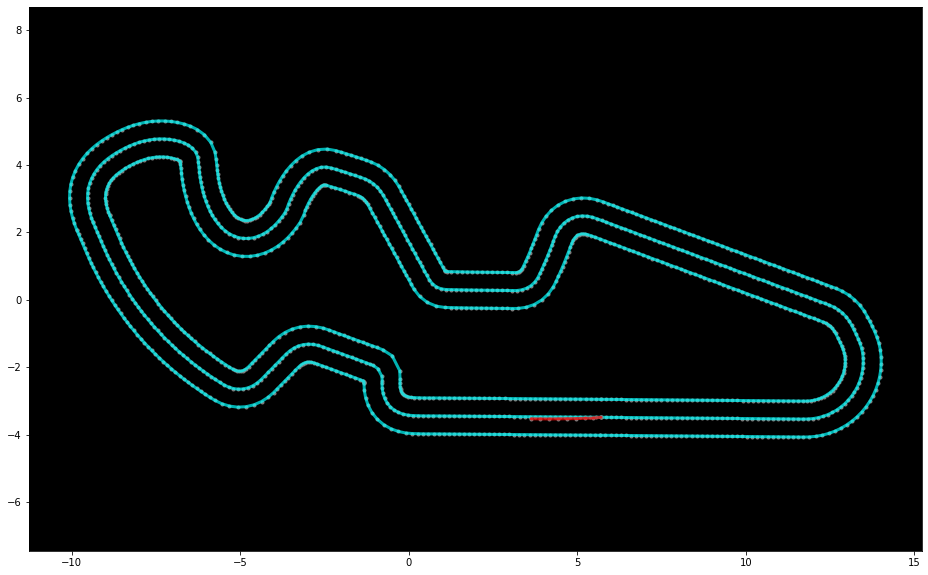

[                                                 ] 3.5%  1.92 sec/iter

Process ForkPoolWorker-239:
Process ForkPoolWorker-227:
Process ForkPoolWorker-234:
Process ForkPoolWorker-230:
Process ForkPoolWorker-225:
Process ForkPoolWorker-240:
Process ForkPoolWorker-236:
Process ForkPoolWorker-232:
Process ForkPoolWorker-231:
Process ForkPoolWorker-233:
Process ForkPoolWorker-237:
Process ForkPoolWorker-235:
Process ForkPoolWorker-226:
Process ForkPoolWorker-238:
Process ForkPoolWorker-229:
Process ForkPoolWorker-228:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [ ]:
# A quick note about the parameters:
#  - n_laps : the number of laps for the race. Should not be finetuned
#  - n_individuals : number of individuals to compare for each epoch. The higher the better and slower
#  - percentage_mutations : percentage of the individual which will have mutations
#  - insertion_rate : rate of insertion (mutation can be either insertion or inplace modification)
#  - look_backward : portion of the track locally optimized. The higher the better and slower

# Note on insertion_rate : the number of insertion is ceiled. If we do 10 mutations and set insertion_rate to 0.05, there should be 1 (=np.ceil(10*0.05)) insertion

action_sequence = compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_individuals=1000,
    number_mutations=5,
    insertion_rate=0.5,
    cut_rate=2,
    look_backward=20,
)

In [ ]:
print(f"Temps fait sur le circuit : {(len(action_sequence) / NUMBER_STEPS_PER_SECOND):.3f} sec")

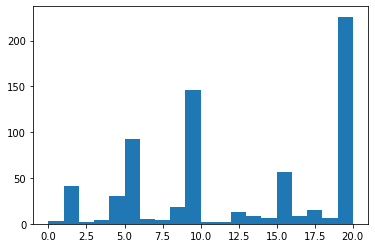

In [44]:
plt.hist(action_sequence, 20)
plt.show()

### Plot the action sequence

In [31]:
real_racing_line = compute_real_racing_line(
    action_sequence, 
    action_space, 
    x0=x0,
    y0=y0,
    theta0=theta0
)

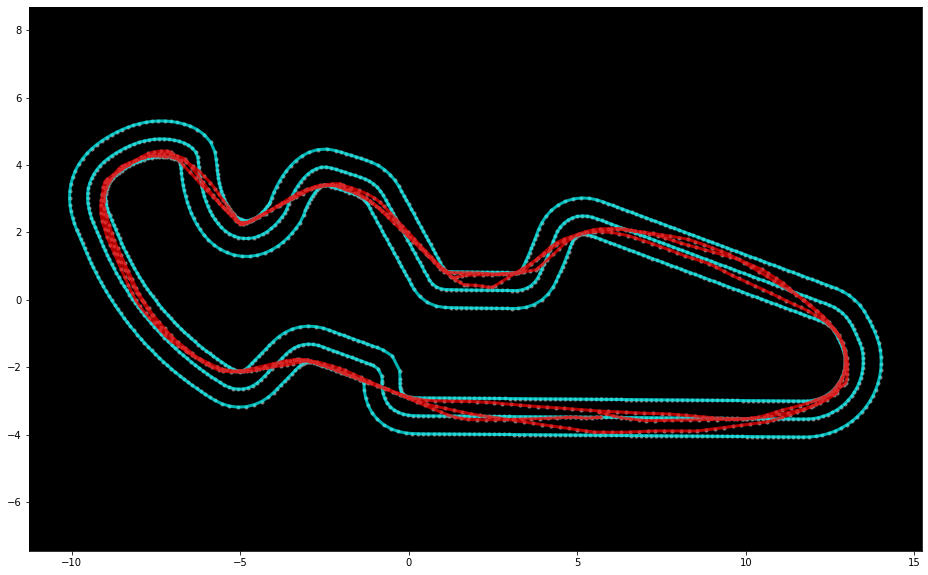

In [32]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)
# print_shape(ax, optimal_racing_line.drop(columns=['speed', 'distance_from_last_point']).values, color='green')
print_shape(ax, real_racing_line.values, color='red')

The blue line is the optimal racing line

The red line is the computed racing line, using only the actions from the action space

# Part 4 - Build the reward function

In [33]:
#les reward élémentaires sont à valeur dans ]0,2]

eps = 1e-3

def reward_function(params):
    
    coeff_exit = 1
    coeff_comp = 1
    coeff_speed = 1
    coeff_steer = 1
    coeff_traj = 1
    
    optimal_racing_line = pd.DataFrame()
    
    exit_track_reward = coeff_exit * exit_track_reward(params)
    completion_reward = coeff_comp * completion_reward(params)
    opti_speed_reward = coeff_speed * opti_speed_reward(params,optimal_racing_line)
    opti_steering_reward = coeff_steer * opti_steering_reward(params,optimal_racing_line)
    opti_trajectory_reward = coeff_traj * opti_trajectory_reward(params,optimal_racing_line)
    
    reward = exit_track_reward + completion_reward + opti_speed_reward + opti_steering_reward + opti_trajectory_reward
    
    return float(reward)

def exit_track_reward(params):
    
    all_wheels_on_track = params['all_wheels_on_track']
    
    if (all_wheels_on_track):
        reward = 1
    else:
        reward = eps
    return float(reward)

def completion_reward(params):
    
    progress = params['progress']
    
    reward = eps+ progress/100.
    if (progress > 90):
        reward += 1
    return float(reward)

def opti_speed_reward(params,optimal_racing_line):
    
    speed = params['speed']
    progress = params['progress']
    
    opti_speed = optimal_racing_line['speed'].values[progress]
    reward = eps+1-abs(speed-opti_speed)/opti_speed
    return float(reward)

def opti_steering_reward(params,optimal_racing_line):
    
    steering_angle = params['steering_angle']
    progress = params['progress']
    
    opti_steering = optimal_racing_line['steering'].values[progress]
    reward = eps+1-abs(steering_angle-opti_steering)/opti_steering
    return float(reward)
    
def racing_trajectory_reward(params,optimal_racing_line):
    
    x,y = params['x'], params['y']
    progress = params['progress']
    
    opti_x = optimal_racing_line['x'].values[progress]
    opti_y = optimal_racing_line['y'].values[progress]
    reward = eps+1-np.sqrt((opti_x-x)**2+(opti_y-y)**2)/np.sqrt(opti_x**2+opti_y**2)
    return float(reward)
